In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from ast import literal_eval
#import nltk
from nltk.tokenize import SpaceTokenizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA   
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE                   

from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imageio
import logging
import random
import re
import numpy as np
from numpy import savez_compressed
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=16)
from tqdm import tqdm
tqdm.pandas()

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


#### Загрузка данных и препроцессинг:

In [7]:
markup = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

In [8]:
train_path = '/home/sergey/Python_projects/RU_NER/Project_Data/Data/train_data.csv'
test_path = '/home/sergey/Python_projects/RU_NER/Project_Data/Data/test_data.csv'

In [9]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [10]:
df_train.sentence= df_train.sentence.astype('str')
df_test.sentence= df_test.sentence.astype('str')

In [11]:
df_train['augmented_ner_tags'] = df_train['augmented_ner_tags'].parallel_apply(literal_eval)
df_test['augmented_ner_tags'] = df_test['augmented_ner_tags'].parallel_apply(literal_eval)

In [12]:
morph = MorphAnalyzer()

# Принимаем слово, возвращаем нормальную форму,
# также используем кэширование для ускорения (много одинаковых итераций):
@lru_cache(maxsize=256)
def lemmatize_word(word):
    return morph.parse(word)[0].normal_form 

# Пробегаемся по корпусу, в каждом куске, пробегаемся по всем словам, передавая их в функцию выше
# и сохраняем преобразованные параграфы:
def lemmatize(text):
    text = ' '.join([lemmatize_word(word) for word in text.split()])
    return text

In [13]:
df_train['processed_sentence'] = df_train.sentence.parallel_apply(lambda x: lemmatize(x))
df_test['processed_sentence'] = df_test.sentence.parallel_apply(lambda x: lemmatize(x))

In [14]:
def len_checker(sentences, processed_sentences):
    len1 = sentences.apply(lambda x: len(x.split()))
    len2 = processed_sentences.apply(lambda x: len(x.split()))             
    return (len1 == len2).value_counts()

In [15]:
len_checker(df_train.sentence, df_train.processed_sentence)

True    205711
dtype: int64

In [ ]:
# @lru_cache(maxsize=256)
# def tokenizer(text):
#     return SpaceTokenizer().tokenize(text) 

In [ ]:
#w2vec_tokens = df_train['processed_sentence'].parallel_apply(lambda x: tokenizer(x))

In [16]:
df_train.head()

,augmented_tokens,sentence,augmented_ner_tags,processed_sentence
0,"['последний', 'был', 'разбит', 'при', 'сауле',...",последний был разбит при сауле жемайтами и зем...,"[0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",последний быть разбитый при саул жемайт и земг...
1,"['научным', 'руководителем', 'был', 'в', 'и', ...",научным руководителем был в и арнольд,"[0, 0, 0, 1, 2, 2]",научный руководитель быть в и арнольд
2,"['но', 'как', 'же', 'нынче', 'выдают', 'замуж'...",но как же нынче выдают замуж княгиня ни от ког...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",но как же нынче выдавать замуж княгиня ни от к...
3,"['в', 'конце', 'финального', 'эпизода', 'сериа...",в конце финального эпизода сериала дверь посре...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",в конец финальный эпизод сериал дверь посредст...
4,"['в', 'начале', 'олигоцена', 'произошло', 'пох...",в начале олигоцена произошло похолодание клима...,"[0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, ...",в начало олигоцен произойти похолодание климат...


In [19]:
# опытным путем была найдена 1 строка с nan, просто удалю ее
df_train.iloc[106405]

augmented_tokens       []
sentence              nan
augmented_ner_tags     []
processed_sentence    nan
Name: 106405, dtype: object

In [20]:
df_train.drop(106405, inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [ ]:
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#### Здесь делал много экспериментов с параметрами векторизации, остановился на таких, показывают себя лучше всего

In [ ]:
#w2v = Word2Vec(w2vec_tokens, sg=1, hs=1,
#                     vector_size=300, window=9, min_count=1, workers=16, epochs=15)

In [ ]:
#w2v.save('baseline_w2v.model')

In [4]:
w2v = Word2Vec.load("./w2v_saved_model/baseline_w2v.model")

In [23]:
def plot_w2v(model, perplexity, frame):
    random.seed(1337)
    keys = random.choices(model.wv.index_to_key[0:5000], k=20)
    embedding_clusters, word_clusters = [], []
    for word in keys:
        embeddings, words = [], []
        for similar_word, _ in model.wv.most_similar(word, topn=7):
            words.append(similar_word)
            embeddings.append(model.wv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne = TSNE(perplexity=perplexity, n_components=2, init='pca', random_state=13, learning_rate='auto')
    embeddings_main = np.array(tsne.fit_transform(embedding_clusters.reshape(n*m, k))).reshape(n,m,2)
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(keys)))
    for key, embeddings, words, colour in zip(keys, embeddings_main, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=colour, alpha=0.75, label=key)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.xlim([-50, 50])
    plt.ylim([-50, 50])
    plt.legend(loc=4)
    plt.title(f'Word2Vec demo with perfepxity={perplexity}')
    plt.grid(True)

/home/sergey/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


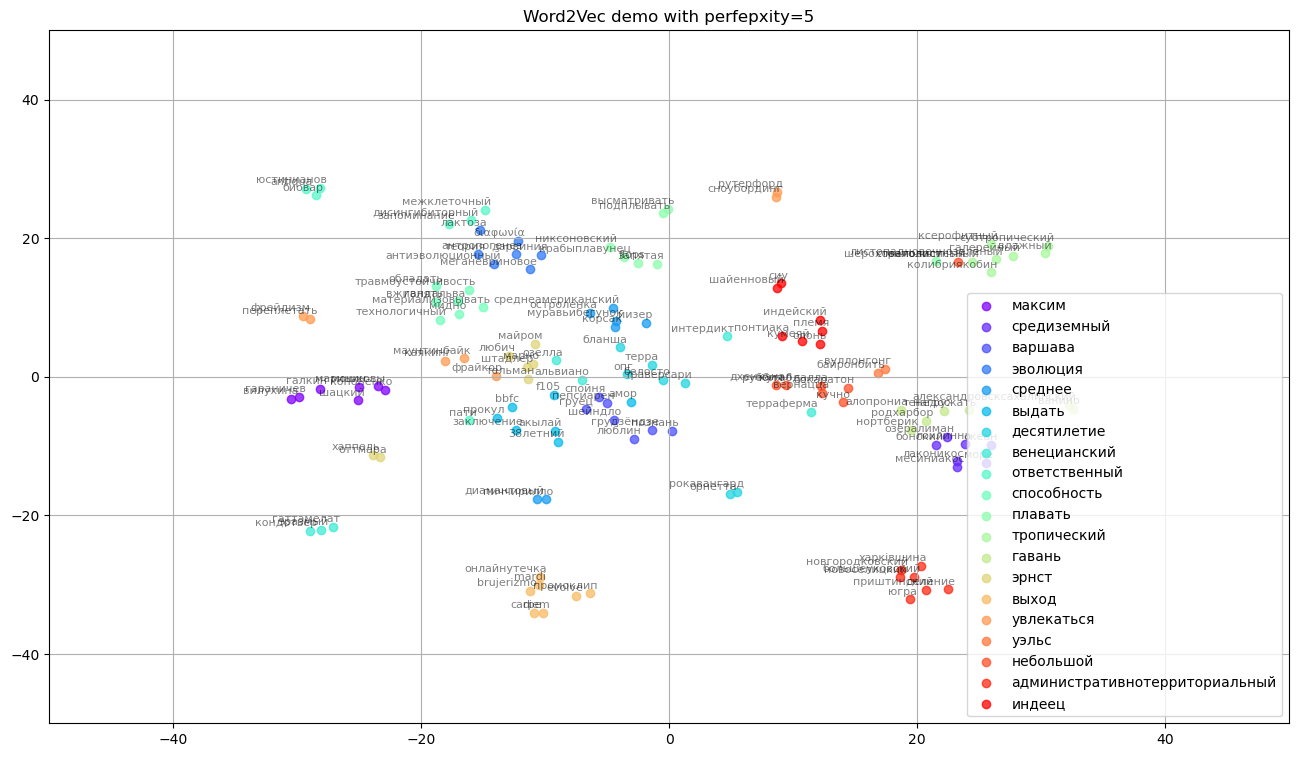

In [24]:
plot_w2v(w2v, 5, 1337)

In [5]:
# helper функция запроса вектора слова
def get_vector(token):
    try:
        return w2v.wv[token]
    except:
        return np.zeros(300)

In [6]:
# еще 1 хелпер вычисляющий коэффициенты для векторов соседних слов в скользящем окне,
# коэффициенты подобраны опутным путем, целевые: [0.15, 0.35, 1, 0.35, 0.15]
# центральный коэффициент - для слова для которого высчитываем вектор,соседние для слов рядом,
# цель функции посчитать это окно в зависимости от наличия соседних слов
# например для первого слова в отрывке текста окно = [1, 0.35, 0.15],
# для последнего [0.15, 0.35, 1]

def get_coefs_2(left, right, index):
    coefs = [1]
    if right == index + 2:
        coefs = [1, 0.35, 0.15]
    elif right == index + 1:
        coefs = [1, 0.35]
    if left == index - 2:
        coefs = [0.15, 0.35] + coefs
    elif left == index -1:
        coefs = [0.35] + coefs
    return coefs

In [7]:
# Функция усреднения вектора для каждого токена в корпусе, 
def get_features_vectors(sentences, ner_markup):
    vectors = []
    ner = []
    for i, sentence in enumerate(sentences):
        ner_row = ner_markup[i]
        n = len(sentence.split())
        for index, word in enumerate(sentence.split()):
            ner.append(ner_row[index])
            left_index = max(0, index-2)
            right_index = min(n-1, index +2)
            coefs = get_coefs_2(left_index, right_index, index)
            window = sentence.split()[left_index:right_index]
            count = (right_index - left_index)+1
            if n == 1:
                vector = get_vector(word)
            else:
                vector = sum([get_vector(word)*coef for word, coef in zip(window, coefs)])/(count**0.45)
            vectors.append(vector)
    return np.array(vectors), ner

#### Небольшой дисклеймер, поскольку я использую 4 датасета, после векторизации данные довольно тяжелые. После использования функций выше на трйене, я получаю numpy array в 6.4 гигабайта. При попытке засунуть его в модель, у меня умирает комп из-за недостатка оперативки. 
#### Одним из решений было бы использование векторов длинны 100 вместо 300, но так я сильно теряю в информации. 
#### Вторым решением было бы использование других ML фреймворков вроде Spark ML, или Dask ML, но я очень не люблю операции в спарке, а Dask ML до сих пор не поддерживает полноценную мультиклассовую регрессию, а использует One-vs-Rest методику, где каждый класс предсказывается против всего остального, упрощая задачу до бинарной классификации.
#### Учитывая что в датасете есть очень много строк с полностью нулевыми токенами, для бейзлайна я уберу их из данных, тем более что при модели я буду подавать не предложения, а вектор токена с учетом его контекста, нулевых токенов все равно останется очень много.
#### p.s. Вообще я видел пример реализации полноценной мультиклассовой регрессии по батчам через Dask, но на то чтобы разобраться в реализации нужно время, а учитывая что идея с регрессией полезна только в рамках моего обучения, и совершеенно не жизнеспособна по сравнению с использованием трансформеров, мне ы хотелось это время потратить на обучение последних:)

In [145]:
check_zeros = lambda x: any(v != 0 for v in x)
df_train = df_train[df_train['augmented_ner_tags'].apply(check_zeros)]
df_train.reset_index(drop=True, inplace=True)
len(df_train)

185213

In [148]:
df_test = df_test[df_test['augmented_ner_tags'].apply(check_zeros)]

#### Даже после удаления части рядов где только нулевые токены, объем сократился примерно на 20%, (это все еще 4 полноценных датасета, на которых обучались другие модели), так что я отрежу 30% данных, с сохранением баланса токенов.

In [151]:
df_main = pd.concat([df_train, df_test], ignore_index=True)

In [225]:
partial_data, _ = train_test_split(df_main, test_size=0.3, random_state=13)

In [226]:
partial_data.reset_index(drop=True, inplace=True)

In [166]:
def print_tags_frequency(tags):
    freq = {}
    for row in tags:
        for tag in set(row):
            if tag in freq:
                freq[tag] += 1
            else:
                freq[tag] = 1
    for item in sorted(freq.keys()):
        print(f'% of rows token {item} appears in is {freq[item]/len(tags)*100:.4f}')

In [170]:
print('Баланс токенов в полном датасете')
print_tags_frequency(df_main['augmented_ner_tags'])

Баланс токенов в полном датасете
% of rows token 0 appears in is 93.3588
% of rows token 1 appears in is 29.2602
% of rows token 2 appears in is 19.1484
% of rows token 3 appears in is 17.3311
% of rows token 4 appears in is 10.1997
% of rows token 5 appears in is 41.3601
% of rows token 6 appears in is 8.3715
% of rows token 7 appears in is 18.1922
% of rows token 8 appears in is 8.7143


In [169]:
print('Баланс токенов в обрезанном датасете')
print_tags_frequency(partial_data['augmented_ner_tags'])

Баланс токенов в обрезанном датасете
% of rows token 0 appears in is 93.3738
% of rows token 1 appears in is 29.2392
% of rows token 2 appears in is 19.1460
% of rows token 3 appears in is 17.4165
% of rows token 4 appears in is 10.2875
% of rows token 5 appears in is 41.4642
% of rows token 6 appears in is 8.4455
% of rows token 7 appears in is 18.1412
% of rows token 8 appears in is 8.6909


In [228]:
#partial_data.to_parquet('partial_data.parquet')

In [8]:
partial_data = pd.read_parquet('partial_data.parquet')

In [9]:
train, test = train_test_split(partial_data, test_size=0.25, random_state=13)

In [10]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [11]:
X_train, y_train = get_features_vectors(train.processed_sentence, train.augmented_ner_tags)

In [14]:
X_test, y_test = get_features_vectors(test.processed_sentence, test.augmented_ner_tags)

In [19]:
model = LogisticRegression(max_iter=400, verbose=1, class_weight='balanced')

In [20]:
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2709     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04419D+06    |proj g|=  2.36481D+04


 This problem is unconstrained.



At iterate   50    f=  2.30511D+06    |proj g|=  2.26233D+03

At iterate  100    f=  2.30300D+06    |proj g|=  5.62133D+02

At iterate  150    f=  2.30297D+06    |proj g|=  1.55469D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2709    180    187      1     0     0   1.055D+01   2.303D+06
  F =   2302965.1498054634     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.6min finished


LogisticRegression(class_weight='balanced', max_iter=400, verbose=1)

In [21]:
y_pred = model.predict(X_test)

Default class weigths:

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94    515207
           1       0.55      0.41      0.47     16224
           2       0.61      0.44      0.52     12506
           3       0.45      0.15      0.22      8894
           4       0.43      0.17      0.24      9087
           5       0.60      0.43      0.50     26708
           6       0.44      0.11      0.17      5238
           7       0.45      0.09      0.15     10410
           8       0.56      0.21      0.31      8278

    accuracy                           0.87    612552
   macro avg       0.55      0.33      0.39    612552
weighted avg       0.85      0.87      0.85    612552



Balanced class weights:

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.65      0.78    515207
           1       0.24      0.55      0.34     16224
           2       0.35      0.63      0.45     12506
           3       0.16      0.46      0.23      8894
           4       0.17      0.40      0.24      9087
           5       0.37      0.62      0.47     26708
           6       0.13      0.64      0.22      5238
           7       0.12      0.53      0.19     10410
           8       0.08      0.49      0.14      8278

    accuracy                           0.63    612552
   macro avg       0.29      0.55      0.34    612552
weighted avg       0.87      0.63      0.71    612552

